# Illustrating the events' detection procedure </a><a name='top'>

This notebook aims at illustrating the different steps to identify snow events.

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.

## Imports and functions

In [1]:
%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 7, time 0).


## Define parameters </a><a name='fill-in'>

In [2]:
dataset_file_name = 'pit_3_2023.nc'

In [3]:
# Figures parameters

fig_1_size = (16, 10)
fig_2_size = (16, 7)

save_figures = False
directory_to_save_figs_in = '/home/mabonnet/github/MB_little_awk/finalized/Results_pits_2023/'
fig_name_1 = 'pit__events_detection.png'
fig_name_2 = 'pit__events_detected.png'

[Back to top section](#top)

## Define dataset and clean data

In [4]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(dataset_file_name)

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7, y_span=7)
median_time_filtering(data_set_used, 11)

# Add the summer surface to the dataset

define_summer_surface(data_set_used, start_summer_surface, end_summer_surface)

# Redefine the zero of the dataset

data_set_used['snow_depth'] = data_set_used['snow_surface'] - data_set_used['summer_surface']


---> Median filtering in space with a window [7, 7]
---> Median filtering in time with a window of 11
---> Summer surface defined based on scans from 2022-10-07 to 2022-10-15


## Get timing values

In [5]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [6]:
# Get timing of snow events

results = get_snow_events(data_set_used, x_isel, y_isel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion= results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


## Plot detection of snow events

Text(0.5, 1.0, '')

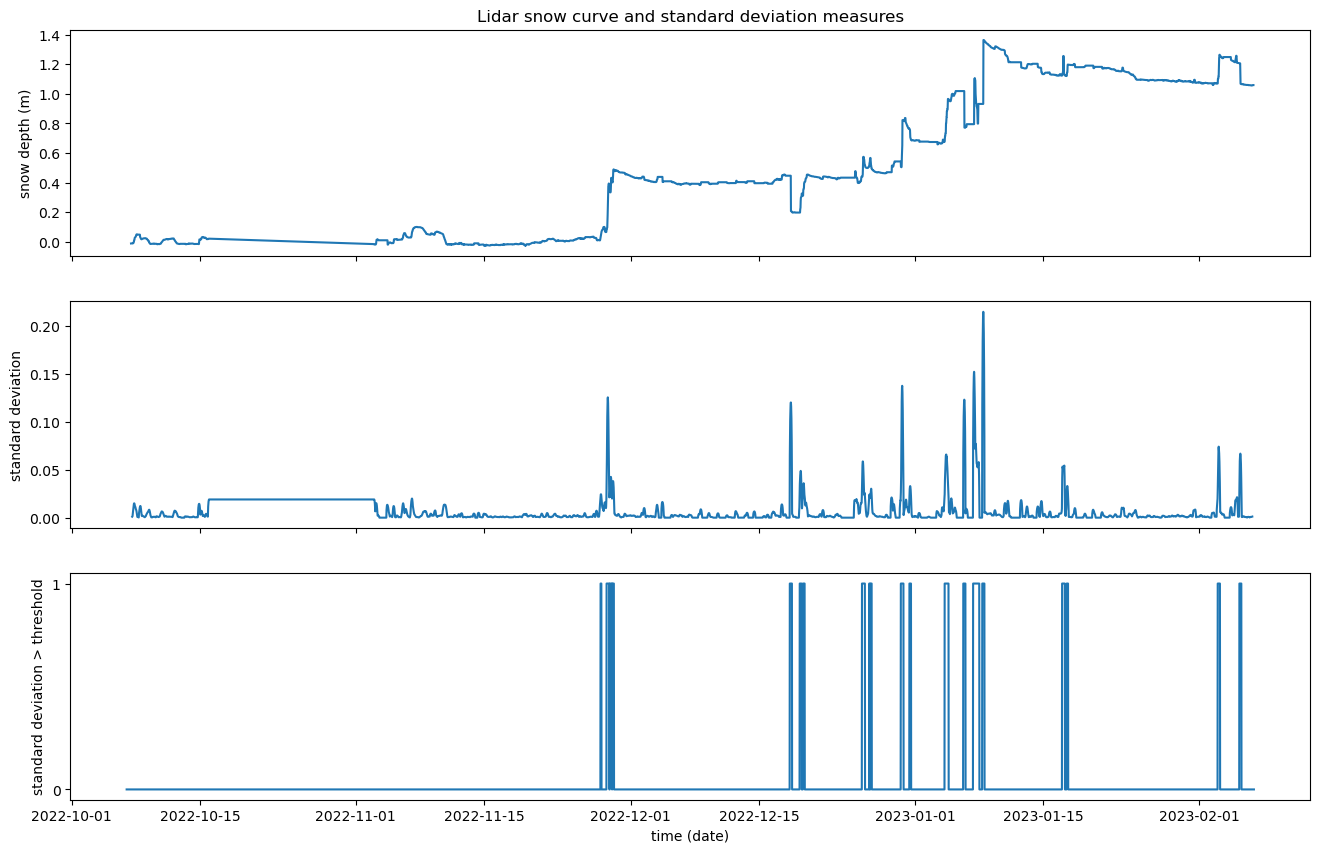

In [7]:
# Plot lidar curve and standard deviation

data_start_date = pd.to_datetime(data_set_used.time.values[0])

stdev = data_set_used.isel(x=x_isel, y=y_isel).snow_depth.rolling(time=time_window_std, center=True).std().values
times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
times = data_set_used.isel(x=x_isel, y=y_isel).time.values

fig, ax = plt.subplots(3, 1, sharex=True, figsize=fig_1_size)

data_set_used.isel(x=x_isel, y=y_isel).snow_depth.plot(ax=ax[0])
ax[0].set_ylabel('snow depth (m)')
ax[0].set_title('Lidar snow curve and standard deviation measures')
ax[0].label_outer()

data_set_used.isel(x=x_isel, y=y_isel).snow_depth.rolling(time=time_window_std, center=True).std().plot(ax=ax[1])
ax[1].set_ylabel('standard deviation')
ax[1].set_title(None)
ax[1].label_outer()

ax[2].plot(times, stdev>std_threshold)
ax[2].set_ylabel('standard deviation > threshold')
ax[2].set_xlabel('time (date)')
ax[2].set_yticks([0, 1])
ax[2].set_title(None)


In [8]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + fig_name_1, bbox_inches = 'tight')

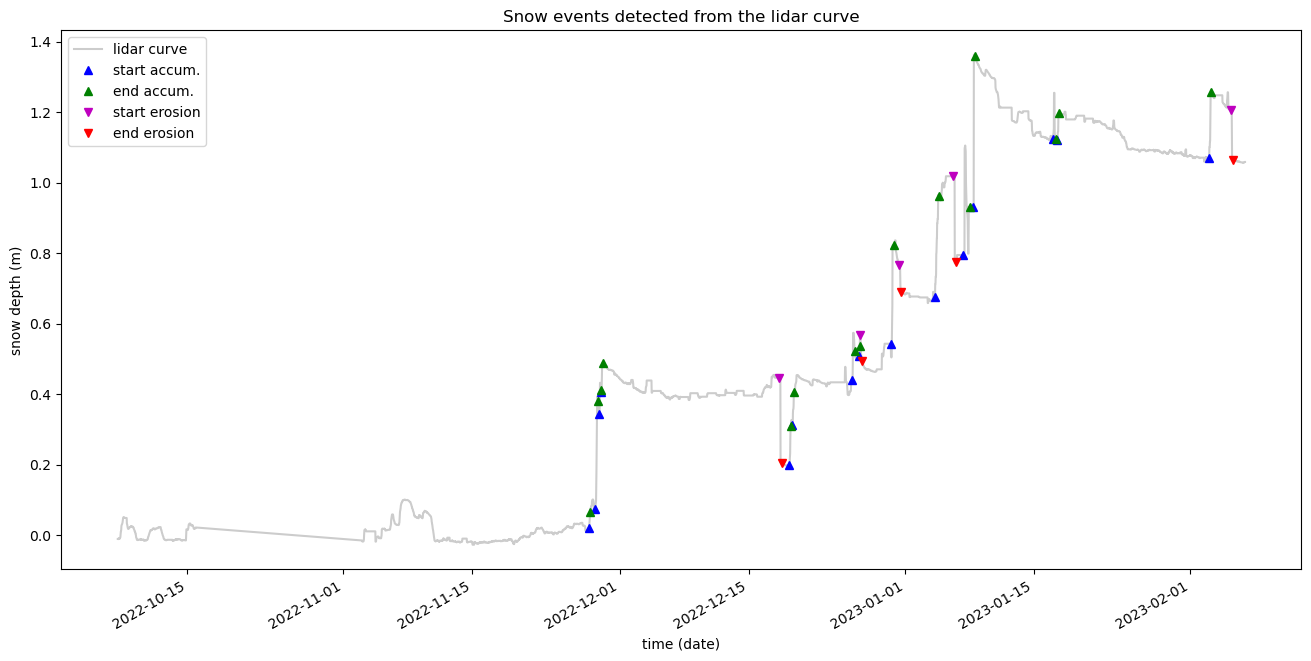

In [9]:
# Plot detected events on lidar curve

fig = plt.figure(figsize=fig_2_size)

data_set_used.isel(x=x_isel, y=y_isel).snow_depth.plot(color='k', alpha=0.2, label='lidar curve')
data_set_used.isel(x=x_isel, y=y_isel, time=start_accumulation).snow_depth.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
data_set_used.isel(x=x_isel, y=y_isel, time=end_accumulation).snow_depth.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
data_set_used.isel(x=x_isel, y=y_isel, time=start_erosion).snow_depth.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
data_set_used.isel(x=x_isel, y=y_isel, time=end_erosion).snow_depth.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')

plt.xlabel('time (date)')
plt.ylabel('snow depth (m)')

plt.title('Snow events detected from the lidar curve')

plt.legend()


In [10]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + fig_name_2, bbox_inches = 'tight')